In [178]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pylab as pl
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif,mutual_info_regression
from itertools import compress
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge

# Data import

In [179]:
trainData = pd.read_csv(r"training.csv")
testData = pd.read_csv(r"test.csv")

In [180]:
trainData.shape

(108000, 122)

In [181]:
testData.shape

(12000, 122)

# Data preprocessing

### Step 1: Missing Value Handling
> * More missing values: discard  
> * Fewer missing values: remove empty rows with empty values or fill      

In [182]:
# Field missing rate display function
def naRatio(miss_analy):
    fig = plt.figure(figsize=(18,6))
    plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',color=['red','green','yellow','steelblue'])
    plt.title('Histogram of missing value of variables')
    plt.xlabel('variables names')
    plt.ylabel('missing rate')
    plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
    pl.xticks(rotation=90)
    for x,y in enumerate(list(miss_analy.missRate.values)):
        plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
    plt.ylim([0,1.2])
    plt.show()

> * Plot the missing rate for different fields

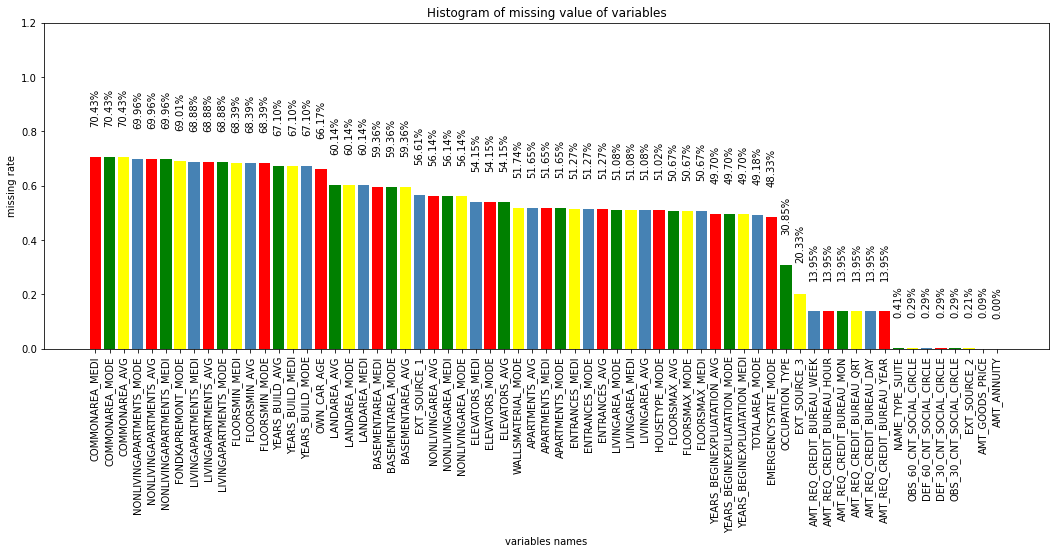

In [183]:
missing=trainData.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate']=missing['missNum']/trainData.shape[0]                                     
missSituation=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)              
naRatio(missSituation)

> * Remove fields with a missing ratio greater than 90%

In [184]:
trainData_dropNanCol=trainData.dropna(thresh=len(trainData)*0.9, axis=1) 
len(trainData_dropNanCol.columns.values)

65

> * for numerical data, if it conforms to a normal distribution, it is appropriate to use the mean to fill, and if it is a skewed distribution, it is appropriate to use the median; 
> * for categorical data, Treat the missing as a separate category, if the previous data has only two categories, then taking the missing into account becomes 3 categories

In [185]:
# trainData_dropNanCol = trainData_dropNanCol.dropna(axis=0)
# trainData_dropNanCol.shape

In [186]:
# Separate continuous and discrete data
trainData_continuous = trainData_dropNanCol.loc[:,[dtype.name != 'object' for dtype in trainData_dropNanCol.dtypes.values.tolist()]] # continuous data
trainData_discrete = trainData_dropNanCol.loc[:,[dtype.name == 'object' for dtype in trainData_dropNanCol.dtypes.values.tolist()]]   # discrete data

# For missing values of continuous variables, fill in with the mean
if(trainData_continuous.shape[1] != 0):
    imp = SimpleImputer(missing_values=np.nan,strategy='mean')
    trainData_fillNan_continuous = pd.DataFrame(imp.fit_transform(trainData_continuous),columns=trainData_continuous.columns)
else:
    trainData_fillNan_continuous = trainData_continuous

# For missing values of discrete features, treat the missing values as a separate category
if(trainData_discrete.shape[1] != 0):
    imp = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value='NA')
    trainData_fillNan_discrete = pd.DataFrame(imp.fit_transform(trainData_discrete),columns=trainData_discrete.columns)
else:
    trainData_fillNan_discrete = trainData_discrete

# concat
trainData_dropNanCol = pd.concat([trainData_fillNan_continuous,trainData_fillNan_discrete],axis=1)
trainData_dropNanCol.shape

(108000, 65)

### Step 2: Processing Typed Features: One-Hot Encoding and Lable Encoding       

> * Observe whether the categories are ordered. If the categories are ordered, use label encoding. If the categories are independent and disordered, use one hot encoding. However, excessive one-hot encoding will cause high-dimensionality question

In [187]:
def dfEncodeDeal(data,calType='oneHot'):
    if(calType == 'oneHot'):
        for item in data.dtypes.unique():
            if(item.type.__name__ == 'object_'):
                categoryColList = data.select_dtypes(item.type.__name__).columns.to_list()
                print('####################Print discrete value ranges of categorical features：####################')
                for col in categoryColList:
                    print(data[col].unique())
                df_onehot = pd.get_dummies(data[categoryColList])    
                data.drop(categoryColList,axis=1,inplace=True)       
                data = pd.concat([data,df_onehot],axis=1)            
                return data
        return None
    elif(calType == 'ordinal'):
        for item in data.dtypes.unique():
            if(item.type.__name__ == 'object_'):
                categoryColList = data.select_dtypes(item.type.__name__).columns.to_list()
                enc = OrdinalEncoder()
                data[categoryColList] = enc.fit_transform(data[categoryColList])
                return data
        return None
                
# test uescase
ret = dfEncodeDeal(trainData_dropNanCol,calType='ordinal')
if (type(ret) != None):
    trainData_encode = ret
else:
    trainData_encode = trainData_dropNanCol
trainData_encode.head(5)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,255237.0,0.0,1.0,427500.0,1842768.0,177826.5,1800000.0,0.046220,-15377.0,-745.0,...,0.0,0.0,1.0,7.0,4.0,1.0,1.0,1.0,4.0,30.0
1,12681.0,0.0,0.0,135000.0,687600.0,18265.5,450000.0,0.024610,-17163.0,-1019.0,...,1.0,1.0,0.0,6.0,7.0,4.0,1.0,1.0,4.0,40.0
2,46342.0,0.0,0.0,315000.0,1067940.0,31356.0,765000.0,0.019101,-9513.0,-498.0,...,1.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,5.0,26.0
3,229866.0,0.0,0.0,132750.0,254700.0,24939.0,225000.0,0.024610,-25076.0,365243.0,...,0.0,0.0,1.0,1.0,3.0,4.0,1.0,1.0,4.0,57.0
4,39700.0,0.0,2.0,112500.0,840996.0,24718.5,702000.0,0.031329,-18228.0,-944.0,...,1.0,1.0,1.0,7.0,7.0,1.0,1.0,4.0,1.0,5.0


### Step 3: Feature scaling (normalization)

In [188]:
scaler=StandardScaler()                            
scaled_values = scaler.fit_transform(trainData_encode) 
trainData_encode.loc[:,:] = scaled_values 
trainData_scaler = trainData_encode

### Step 4: Outlier Filter  

In [189]:
clf = IsolationForest(contamination=.1)
y_pred_train = clf.fit_predict(trainData_scaler.values)
trainData_outlierdel = trainData_scaler[np.where(y_pred_train == 1, True, False)] #Remove outliers where 1 represent inliers and -1 represent outliers:
trainData_outlierdel.shape

(97200, 65)

### Step 5: Conclusion

In [190]:
def trainProcess(data,targetCol,outlierFilterMethod='ordinal'):
    targetColSeries = data[targetCol]
    data = data.drop([targetCol], axis=1)
    # Missing value handling
    data=data.dropna(thresh=len(data)*0.9, axis=1) #Remove fields with high missing rate
    # Separate continuous and discrete data
    trainData_continuous = data.loc[:,[dtype.name != 'object' for dtype in data.dtypes.values.tolist()]] # continuous data
    trainData_discrete = data.loc[:,[dtype.name == 'object' for dtype in data.dtypes.values.tolist()]]   # discrete data
    # For missing values of continuous variables, fill in with the mean
    if(trainData_continuous.shape[1] != 0):
        imp = SimpleImputer(missing_values=np.nan,strategy='mean')
        trainData_fillNan_continuous = pd.DataFrame(imp.fit_transform(trainData_continuous),columns=trainData_continuous.columns)
    else:
        trainData_fillNan_continuous = trainData_continuous
    # For missing values of discrete features, treat the missing values as a separate category
    if(trainData_discrete.shape[1] != 0):
        imp = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value='NA')
        trainData_fillNan_discrete = pd.DataFrame(imp.fit_transform(trainData_discrete),columns=trainData_discrete.columns)
    else:
        trainData_fillNan_discrete = trainData_discrete
    # concat
    data = pd.concat([trainData_fillNan_continuous,trainData_fillNan_discrete],axis=1)
    targetColSeries = targetColSeries.filter(items=list(data.index.values),axis=0)
    # Handling Typed Features
    def dfEncodeDeal(data,calType='oneHot'):
        if(calType == 'oneHot'):
            for item in data.dtypes.unique():
                if(item.type.__name__ == 'object_'):
                    categoryColList = data.select_dtypes(item.type.__name__).columns.to_list()
#                     print('####################Print discrete value ranges of categorical features：####################')
#                     for col in categoryColList:
#                         print(data[col].unique())
                    df_onehot = pd.get_dummies(data[categoryColList])    
                    data.drop(categoryColList,axis=1,inplace=True)       
                    data = pd.concat([data,df_onehot],axis=1)            
                    return data
            return None
        elif(calType == 'ordinal'):
            for item in data.dtypes.unique():
                if(item.type.__name__ == 'object_'):
                    categoryColList = data.select_dtypes(item.type.__name__).columns.to_list()
                    enc = OrdinalEncoder()
                    data[categoryColList] = enc.fit_transform(data[categoryColList])
                    return data
            return None
    ret = dfEncodeDeal(data,calType=outlierFilterMethod)
    if (type(ret) != None):
        data = ret
        
    # Feature scaling (normalization)
    scaler=StandardScaler()                            
    scaled_values = scaler.fit_transform(data) 
    data.loc[:,:] = scaled_values 
    
    # Outlier Removal
#     clf = IsolationForest(contamination=.1)
#     y_pred_train = clf.fit_predict(data.values)
#     data = data[np.where(y_pred_train == 1, True, False)]
#     targetColSeries = targetColSeries.filter(items=list(data.index.values),axis=0)
    
    return (data,targetColSeries)

print('regress train dataSet\n')
ret = trainProcess(trainData,'AMT_INCOME_TOTAL','ordinal')
trainData_regression = ret[0]
targetColSeries_regression = ret[1]
print(trainData_regression.shape)
print(targetColSeries_regression.shape)

print('classification train dataSet\n')
ret = trainProcess(trainData,'TARGET','oneHot')
trainData_classification = ret[0]
targetColSeries_classification = ret[1]
print(trainData_classification.shape)
print(targetColSeries_classification.shape)

regress train dataSet

(108000, 64)
(108000,)
classification train dataSet

(108000, 159)
(108000,)


# Feature selection

### Step 1: Variance filtering

In [191]:
# Draw a learning curve
def plotSquaredCurve(data,target,type):
    score = []
    for i in range(0,80,5):
        try:
            print("current i={0}\n".format(i))
            print("var percentile={0}".format(round(np.percentile(data.var().values, i),20)))
            vt = VarianceThreshold(threshold=round(np.percentile(data.var().values, i),20))     # Filtering with variance below a quantile
            data = pd.DataFrame(vt.fit_transform(data),columns=data.columns[vt.get_support()])
            if(type == 'Regressor'):
                once = cross_val_score(RandomForestRegressor(n_estimators=10,random_state=0),data,target,cv=5,n_jobs=-1).mean()
            elif(type == 'Classifier'):
                once = cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),data,target,cv=5,n_jobs=-1).mean()
            score.append(once)
        except:
            score.append(None)
    plt.plot(range(0,80,5),score)
    plt.show()

> * It can be seen from the score curve of cross-validation that when using the feature selection method based on variance filtering, taking the 80% quantile of variance to filter features will achieve relatively good results.

In [192]:
# plotSquaredCurve(trainData_classification,targetColSeries_classification,'Classifier')

In [193]:
# plotSquaredCurve(trainData_regression,targetColSeries_regression,'Regressor')

In [194]:
# Variance filtering in classification problems

# Comparison of precision before and after filtering
def filterCompare_Classifier(x_before,x_after,y):
    print('before: {0}\n'.format(cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),x_before,y,cv=5).mean()))
    print('after: {0}\n'.format(cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),x_after,y,cv=5).mean()))
    
vt = VarianceThreshold(threshold=0)    # np.percentile(trainData_classification.var().values, 80)
trainData_classification_varfilter = pd.DataFrame(vt.fit_transform(trainData_classification),columns=trainData_classification.columns[vt.get_support()] )
print(trainData_classification_varfilter.shape)
# See if there is an improvement before and after variance filtering
filterCompare_Classifier(trainData_classification,trainData_classification_varfilter,targetColSeries_classification) 

(108000, 158)
before: 0.8291759259259258

after: 0.8300000000000001



In [195]:
# Variance filtering in regression problems

# Comparison of precision before and after filtering
def filterCompare_Regressor(x_before,x_after,y):
    print('before: {0}\n'.format(cross_val_score(RandomForestRegressor(n_estimators=10,random_state=0),x_before,y,cv=5).mean()))
    print('after: {0}\n'.format(cross_val_score(RandomForestRegressor(n_estimators=10,random_state=0),x_after,y,cv=5).mean()))
    
vt = VarianceThreshold(threshold=0)     #np.percentile(trainData_regression.var().values, 80)
trainData_regression_varfilter = pd.DataFrame(vt.fit_transform(trainData_regression),columns=trainData_regression.columns[vt.get_support()] )
print(trainData_regression_varfilter.shape)
# See if there is an improvement before and after variance filtering
filterCompare_Regressor(trainData_regression,trainData_regression_varfilter,targetColSeries_regression) 

(108000, 63)
before: -0.878561182443265

after: -1.275758113745288



##### Summarize

In [196]:
# Variance filtering in classification
vt = VarianceThreshold(threshold=0)      # np.percentile(trainData_classification.var().values, 80)
trainData_classification_varfilter = pd.DataFrame(vt.fit_transform(trainData_classification),columns=trainData_classification.columns[vt.get_support()])
# Variance filtering in regression 
vt = VarianceThreshold(threshold=0)     # np.percentile(trainData_regression.var().values, 80)
trainData_regression_varfilter = pd.DataFrame(vt.fit_transform(trainData_regression),columns=trainData_regression.columns[vt.get_support()] )

### Step 2: Correlation Filtering (MIC)

#### Relevance Filtering Based on Classification Problems，It can be seen from the cross-check that there is an improvement,The classical mutual information evaluates the correlation between qualitative independent variables and qualitative dependent variables.

In [197]:
# Eliminate irrelevant ones
result = mutual_info_classif(trainData_classification_varfilter,targetColSeries_classification) 
k = result.shape[0] - sum(result == 0)  
print('Number of features after correlation filtering:{0}'.format(k))

Number of features after correlation filtering:136


In [198]:
X_fsmic = SelectKBest(mutual_info_classif, k=k).fit_transform(trainData_classification_varfilter, targetColSeries_classification) 
cross_val_score(RandomForestClassifier(n_estimators=10,random_state=0),X_fsmic,targetColSeries_classification,cv=5).mean()

0.8304814814814815

In [199]:
col = trainData_classification_varfilter.columns.values.tolist()
trainData_classification_correlationFilter = trainData_classification_varfilter[list(compress(col, list(result!=0)))]
trainData_classification_correlationFilter.columns.values.tolist()

['SK_ID_CURR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'NAME_CONTRACT

#### Relevance Filtering Based on regression problem，It can be seen from the cross-check that there is no improvement

In [200]:
# Eliminate irrelevant ones
result = mutual_info_regression(trainData_regression_varfilter,targetColSeries_regression) 
k = result.shape[0] - sum(result == 0)  
print('Number of features after correlation filtering:{0}'.format(k))

Number of features after correlation filtering:51


In [201]:
X_fsmic = SelectKBest(mutual_info_regression, k=k).fit_transform(trainData_regression_varfilter, targetColSeries_regression) 
cross_val_score(RandomForestRegressor(n_estimators=10,random_state=0),X_fsmic,targetColSeries_regression,cv=5).mean()

-1.6502447246706826

In [202]:
col = trainData_regression_varfilter.columns.values.tolist()
trainData_regression_correlationFilter = trainData_regression_varfilter[list(compress(col, list(result!=0)))]
trainData_regression_correlationFilter.columns.values.tolist()
trainData_regression_correlationFilter.columns.values.tolist()

['TARGET',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY'

##### Summarize

In [203]:
result = mutual_info_classif(trainData_classification_varfilter,targetColSeries_classification) 
col = trainData_classification_varfilter.columns.values.tolist()
trainData_classification_correlationFilter = trainData_classification_varfilter[list(compress(col, list(result!=0)))]

result = mutual_info_regression(trainData_regression_varfilter,targetColSeries_regression) 
col = trainData_regression_varfilter.columns.values.tolist()
trainData_regression_correlationFilter = trainData_regression_varfilter[list(compress(col, list(result!=0)))]

# Test set missing value imputation

### Step 1: Missing Value Handling

In [204]:
# Separate continuous and discrete data
testData_continuous = testData.loc[:,[dtype.name != 'object' for dtype in testData.dtypes.values.tolist()]] # continuous data
testData_discrete = testData.loc[:,[dtype.name == 'object' for dtype in testData.dtypes.values.tolist()]]   # discrete data

# For missing values of continuous variables, fill in with the mean
if(testData_continuous.shape[1] != 0):
    imp = SimpleImputer(missing_values=np.nan,strategy='mean')
    testData_fillNan_continuous = pd.DataFrame(imp.fit_transform(testData_continuous),columns=testData_continuous.columns)
else:
    testData_fillNan_continuous = testData_continuous

# For missing values of discrete features, treat the missing values as a separate category
if(testData_discrete.shape[1] != 0):
    imp = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value='NA')
    testData_fillNan_discrete = pd.DataFrame(imp.fit_transform(testData_discrete),columns=testData_discrete.columns)
else:
    testData_fillNan_discrete = testData_discrete

# concat
testData_dealNan = pd.concat([testData_fillNan_continuous,testData_fillNan_discrete],axis=1)
testData_dealNan.shape

(12000, 122)

### Step 2: Processing Typed Features: One-Hot Encoding and Lable Encoding  

In [205]:
def encodeDeal(targetCol,calType):
    targetColSeries = testData_dealNan[targetCol]
    data = testData_dealNan.drop([targetCol], axis=1)
    def dfEncodeDeal(data,calType='oneHot'):
        if(calType == 'oneHot'):
            for item in data.dtypes.unique():
                if(item.type.__name__ == 'object_'):
                    categoryColList = data.select_dtypes(item.type.__name__).columns.to_list()
#                     print('####################Print discrete value ranges of categorical features：####################')
#                     for col in categoryColList:
#                         print(data[col].unique())
                    df_onehot = pd.get_dummies(data[categoryColList])    
                    data.drop(categoryColList,axis=1,inplace=True)       
                    data = pd.concat([data,df_onehot],axis=1)            
                    return data
            return None
        elif(calType == 'ordinal'):
            for item in data.dtypes.unique():
                if(item.type.__name__ == 'object_'):
                    categoryColList = data.select_dtypes(item.type.__name__).columns.to_list()
                    enc = OrdinalEncoder()
                    data[categoryColList] = enc.fit_transform(data[categoryColList])
                    return data
            return None
    ret = dfEncodeDeal(data,calType=calType)
    if (type(ret) != None):
        data = ret
    return (data,targetColSeries)
    
ret = encodeDeal('TARGET','oneHot')
testData_classification_data = ret[0]
testData_classification_target = ret[1]

ret = encodeDeal('AMT_INCOME_TOTAL','ordinal')
testData_regression_data = ret[0]
testData_regression_target = ret[1]

### Step 3: Feature scaling (normalization)

In [206]:
# Feature scaling (normalization)
def scale(data):
    scaler=StandardScaler()                            
    scaled_values = scaler.fit_transform(data) 
    data.loc[:,:] = scaled_values
    return data

testData_classification_data = scale(testData_classification_data)
testData_regression_data = scale(testData_regression_data)

# Classification

### 1.Training set and test set processing

In [207]:
# Training set
X_train = trainData_classification_correlationFilter
y_train = targetColSeries_classification

# test set
X_test = testData_classification_data
y_test = testData_classification_target

# Ensure that the dimensions of the training set and the test set are the same
features = X_train.columns.values.tolist()
features = list(set(features).intersection(set(X_test.columns.values.tolist())))
X_train = X_train[features]
X_test = X_test[features]

### 2.Choose a classification model

> * #### MultinomialNB   
> I recommend you that don't use Naive Bayes with SVD or other matrix factorization because Naive Bayes 
    based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

In [208]:
# model = MultinomialNB(alpha=0.01)  # Multinomial Naive Bayes Classifier

> * #### KNeighborsClassifier     
> One of the advantages of KNN is that the model is easy to understand and does not require too much tuning to get good performance. 
    It is a good benchmark to try this algorithm before considering more advanced techniques. Building a nearest neighbor model is 
    usually fast, but if the training set is large (large number of features or large number of samples), prediction speed can be slow. 
    When using the KNN algorithm, it is important to preprocess the data, this algorithm often does not work well for datasets with many 
    features (hundreds or more), and most of the features are 0. This algorithm works especially poorly for datasets (so-called sparse 
    datasets).

In [209]:
# model = KNeighborsClassifier() 

> * #### LogisticRegression   
> The calculation amount during classification is very small, the speed is very fast, and the storage resources are low;   
> For logistic regression, multicollinearity is not a problem, it can be solved with L2 regularization;   
> Can only handle two classification problems   

In [210]:
model = LogisticRegression(penalty='l2')

> * #### DecisionTreeClassifier   
> parameter:   
    > 1.criterion: 
        Either "gini" or "entropy" can be used, the former representing the Gini coefficient and the latter representing the information gain. Generally speaking, it is enough to use the default Gini coefficient "gini".   
    > 2.splitter:      
        Either "best" or "random" can be used. The former finds the optimal division point among all the division points of the feature. The latter is to randomly find the locally optimal dividing point among the partial dividing points.  
    > 3.max_features:   
        Many types of values ​​can be used, the default is "None", which means that all features are considered when dividing; if it is "log2", it means that at most log2N features are considered when dividing;   
    > 4.max_depth:   
        The maximum depth of the decision tree can not be entered by default. If it is not entered, the decision tree will not limit the depth of the subtree when building the subtree. Generally speaking, this value can be ignored when there are few data or features.    
    > 5.min_impurity_split:   
        This value limits the growth of the decision tree. If the impurity of a node (Gini coefficient, information gain, mean square error, absolute difference) is less than this threshold, the node will no longer generate child nodes. is the leaf node .   


In [211]:
# model = tree.DecisionTreeClassifier()

> * #### GradientBoostingClassifier:
> Gradient Boosting is a Boosting method. Its main idea is that each time a model is built, the gradient descent direction of the model loss function is established before.

In [212]:
# model = GradientBoostingClassifier(n_estimators=200)

> * #### svm:   
> The SVM classifier is a binary or discriminative model that distinguishes between two types of data

In [213]:
# model = SVC(kernel='rbf', probability=True) 

> * #### RandomForestClassifier     
> The goal of the ensemble algorithm is to consider the modeling results of multiple evaluators and aggregate them to obtain a comprehensive result, in order to obtain better regression or classification performance than a single model.   

In [214]:
# model = RandomForestClassifier(n_estimators=1000,max_depth=10)

In [215]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)
report = classification_report(y_test, prediction, output_dict=True)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### Evaluate

In [216]:
df_evaluate = pd.DataFrame([["5330254",report["macro avg"]["precision"],report["macro avg"]["recall"],report["accuracy"]]],
             columns=["zid","average_precision","average_recall","accuracy"])
df_evaluate

,zid,average_precision,average_recall,accuracy
0,5330254,0.676872,0.51665,0.83375


#### prediction output

In [217]:
df_predict = pd.concat([pd.Series(X_test.index.values),pd.Series(prediction)],axis=1)
df_predict.columns = ['SK_ID_CURR','predicted_target']
df_predict

,SK_ID_CURR,predicted_target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
11995,11995,0
11996,11996,0
11997,11997,0
11998,11998,0


In [218]:
df_predict.predicted_target.unique()

array([0, 1], dtype=int64)

# Regression

In [219]:
from sklearn import tree
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.stats import pearsonr

In [220]:
# Training set
X_train = trainData_regression_correlationFilter
y_train = targetColSeries_regression
y_trainMean = y_train.mean()
y_trainStd = y_train.std()
y_train = y_train.apply(lambda x: (x-y_trainMean)/y_trainStd)

# test set
X_test = testData_regression_data
y_test = testData_regression_target
y_testMean = y_test.mean()
y_testStd = y_test.std()
y_test = y_test.apply(lambda x: (x-y_trainMean)/y_trainStd)

# Ensure that the dimensions of the training set and the test set are the same
features = X_train.columns.values.tolist()
features = list(set(features).intersection(set(X_test.columns.values.tolist())))
X_train = X_train[features]
X_test = X_test[features]

> LinearRegression

In [221]:
# model = LinearRegression()

> DecisionTreeRegressor

In [222]:
# model = tree.DecisionTreeRegressor()

> KNeighborsRegressor

In [223]:
# model = KNeighborsRegressor()

> RandomForestRegressor

In [224]:
# model = RandomForestRegressor(n_estimators=20)

> AdaBoostRegressor

In [225]:
# model = AdaBoostRegressor(n_estimators=50)

> GradientBoostingRegressor

In [226]:
# model = GradientBoostingRegressor(n_estimators=100)

> BaggingRegressor

In [227]:
# model = BaggingRegressor()

> Ridge
    > Choose Ridge Regression Hyperparameter α

In [228]:
ridgecv = RidgeCV(alphas=[0.01, 0.1, 0.5, 1, 3, 5, 7, 10, 20, 100])
ridgecv.fit(X_train, y_train)
ridgecv.alpha_ 

5.0

In [229]:
model = Ridge(alpha=ridgecv.alpha_)

In [230]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [231]:
df_evaluate = pd.DataFrame([["5330254",mean_squared_error(y_test, prediction),pearsonr(y_test, prediction)[0]]],
             columns=["zid","MSE","correlation"])
df_evaluate

,zid,MSE,correlation
0,5330254,0.068077,0.508406


In [232]:
df_predict = pd.concat([pd.Series(X_test.index.values),pd.Series(prediction.tolist()).apply(lambda x: x*y_testStd+y_testMean)],axis=1)
df_predict.columns = ['SK_ID_CURR','predicted_income']
df_predict

,SK_ID_CURR,predicted_income
0,0,168714.488444
1,1,143296.779749
2,2,178386.171656
3,3,197307.293532
4,4,153267.476605
...,...,...
11995,11995,156266.118464
11996,11996,171268.291516
11997,11997,184488.110381
11998,11998,169076.129025
